In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/Users/minyan/Desktop/Python Project/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [25]:
#check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [26]:
#list how many null values for each feature
print(df.isnull().sum().sort_values(ascending=False))

retention_7       0
retention_1       0
sum_gamerounds    0
version           0
userid            0
dtype: int64


In [27]:
#count the number of players in each group
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


In [28]:
df.groupby('version')['sum_gamerounds'].mean()

version
gate_30    52.456264
gate_40    51.298776
Name: sum_gamerounds, dtype: float64

In [29]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

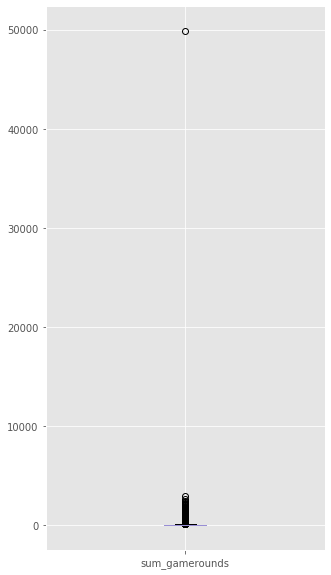

In [30]:
df['sum_gamerounds'].plot.box(figsize=(5,10))

In [31]:
#counting the number of palyers for each of gamerounds
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

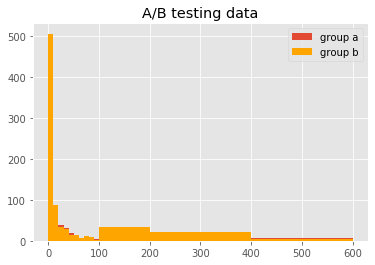

In [43]:
plot_ga=df[df['version']=='gate_30'].groupby('sum_gamerounds')['userid'].count()
plot_gb=df[df['version']=='gate_40'].groupby('sum_gamerounds')['userid'].count()

#visualising A/B testing data
bins= [0,10,20,30,40,50,60,70,80,90, 100, 200, 400, 600]
plt.hist(plot_ga, bins=bins,label ='group a')
plt.hist(plot_gb, bins=bins, label = 'group b', color='orange')
plt.title('A/B testing data')
plt.legend()

Text(0.5, 0, '# of Game rounds')

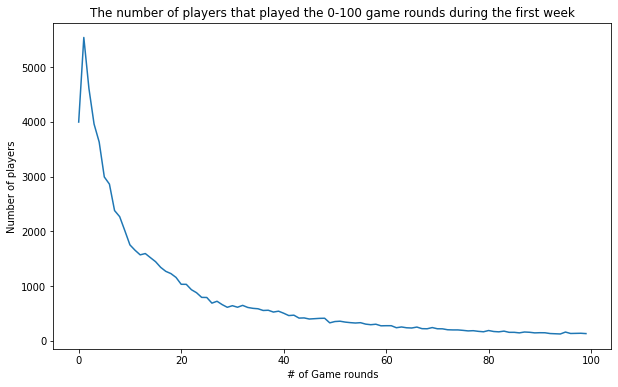

In [11]:
#plot the distribution of players that played 0 to 100 game rounds
%matplotlib inline

ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played the 0-100 game rounds during the first week")
ax.set_ylabel('Number of players')
ax.set_xlabel('# of Game rounds')

In [ ]:
#Null hypothesis: the difference of conversion rate between a/b group is by chance
#Alternative hypothesis: conversion rate of group a is statistical significant larger then group b

In [16]:
#overall one-day retention
#A common metric measuign how fun and engaging a game is 1-day retention
#calculate p_pool

p_pool = df['retention_1'].sum()/df['retention_1'].count()

In [17]:
#A/B test retention for each AB group
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

In [18]:
#Solution 1:calculate the mean difference
p_diff=df[df['version']== "gate_30"]['retention_1'].mean()-df[df['version']== "gate_40"]['retention_1'].mean()
p_diff

0.005905169787341458

In [19]:
#calculate pooled standard error 
count1=df[df['version']== "gate_30"]['retention_1'].count()
count2=df[df['version']== "gate_40"]['retention_1'].count()
se_pool = np.sqrt(p_pool*(1-p_pool)*(1/count1+1/count2))
se_pool

0.0033099127751024513

In [20]:
#for 95% confidence interval the value of Z is 1.96 or we can use pcipy package to calculate it
from scipy.stats import norm
alpha=0.05
z=round(norm.ppf(1-alpha/2),2)
#calculate marginal error
marginal_error = round((z*se_pool),4)
marginal_error

lb=p_diff-marginal_error
ub=p_diff+marginal_error

if lb>0:
    print('Reject null hypothesis.')
else:
    print('Do not reject null hypothesis')

Do not reject null hypothesis


In [47]:
#Solution 2: Bootstrapping: should we be confident in the difference?
#predict the statistics under the null hypothesis

version       gate_30   gate_40
retention_1  0.450437  0.446082
retention_1  0.442857  0.441316
retention_1  0.451167  0.443204
retention_1  0.445370  0.441910
retention_1  0.447912  0.441211
...               ...       ...
retention_1  0.452484  0.444026
retention_1  0.444377  0.445433
retention_1  0.448397  0.441194
retention_1  0.452051  0.440561
retention_1  0.445975  0.441040

[1000 rows x 2 columns]
Object `plot` not found.


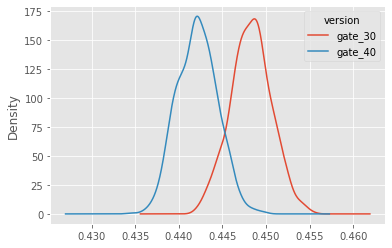

In [55]:
#create a list with bootstrappwd means for each AB-group
boot_1d=[]
for i in range(1000):
    boot_mean=df.sample(frac = 1, replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
#transform the list to a Dataframe
boot_1d=pd.DataFrame(boot_1d)
print(boot_1d)

# A kernel Density estimate plot of the boostrap distributiona
boot_1d.plot(kind='density')

Probablity that 1-day retention is greater when the gate is at level 30: 0.965


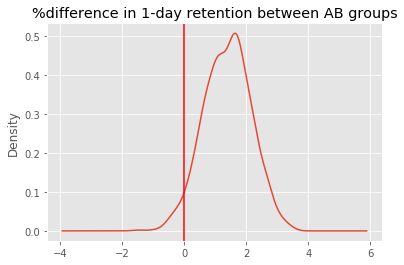

In [56]:
#add a column with the difference between AB group
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

#plot the bootstrap % difference
ax = boot_1d['diff'].plot(kind = 'density')
ax.set_title('%difference in 1-day retention between AB groups')
ax.axvline(x=p_diff, color= 'r')

#calculate the probablity that 1-day retention is greater when the gate is at level 30
print('Probablity that 1-day retention is greater than observed difference when the gate is at level 30:', (boot_1d['diff']>p_diff).mean())
#We can't reject Ho because p-value(0.965>0.05), the difference is insignificant.
